# Saved Plots

 25%|██▌       | 37335/149049 [00:00<00:00, 373344.13it/s]

Populating arrays from 999 to 150048 for a length of 149049...
Using classes from 0 to 1 for total of 1 classes


100%|██████████| 149049/149049 [00:00<00:00, 408490.83it/s]


Plotting...


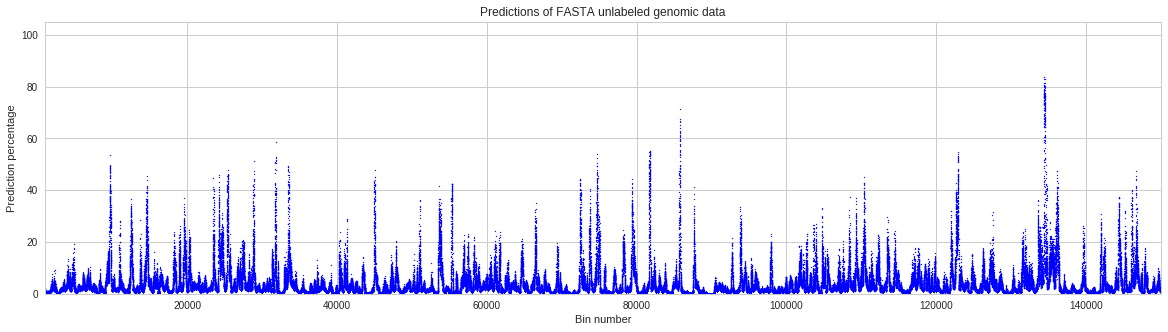

In [242]:
x, y = plot_predictions_sliding()

100%|██████████| 10000/10000 [00:00<00:00, 408232.58it/s]

Using viewing window of size 20 x 5
Populating arrays from 20000 to 30000 for a length of 10000...
Using classes from 0 to 1 for total of 1 classes
Plotting...


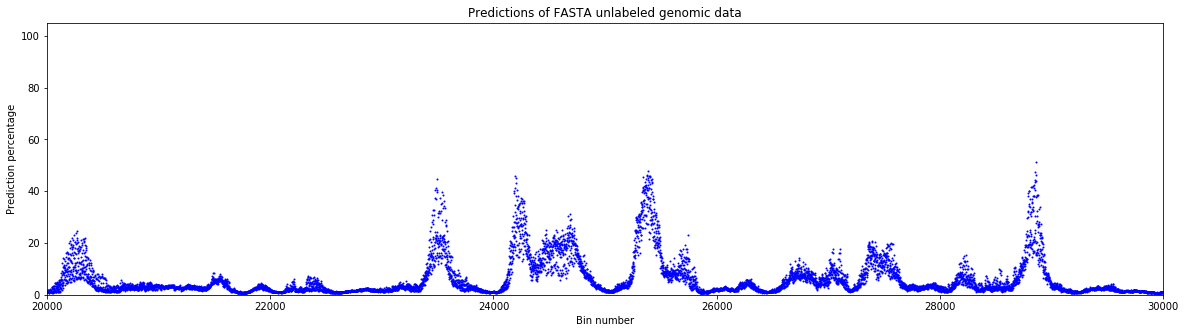

In [224]:
x, y = plot_predictions_sliding()

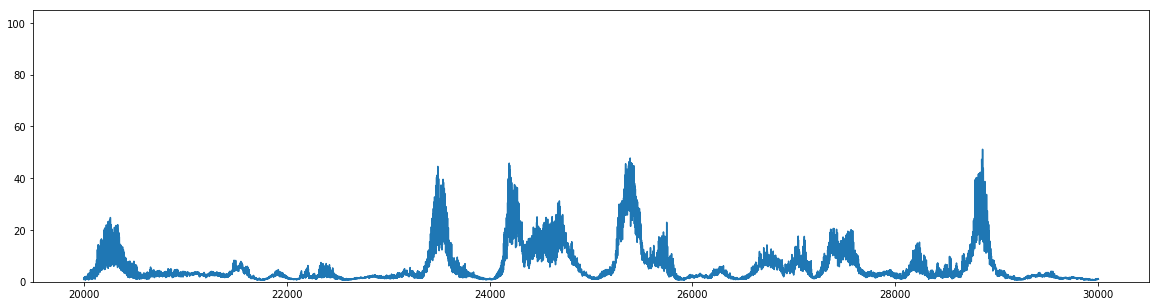

In [202]:
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
def interpolate_curve(x, y):
    """
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splprep.html#scipy.interpolate.splprep
    """
    tck, u = splprep([x, y], s=0)
    new_points = splev(u, tck)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(new_points[0], new_points[1])
    plt.ylim(0.0, 105)
    plt.show()
    
interpolate_curve(x[0], y[0])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     22.35
Date:                Tue, 21 Mar 2017   Prob (F-statistic):           2.30e-06
Time:                        04:38:41   Log-Likelihood:                -33921.
No. Observations:               10000   AIC:                         6.785e+04
Df Residuals:                    9998   BIC:                         6.786e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0668      0.627      4.890      0.0

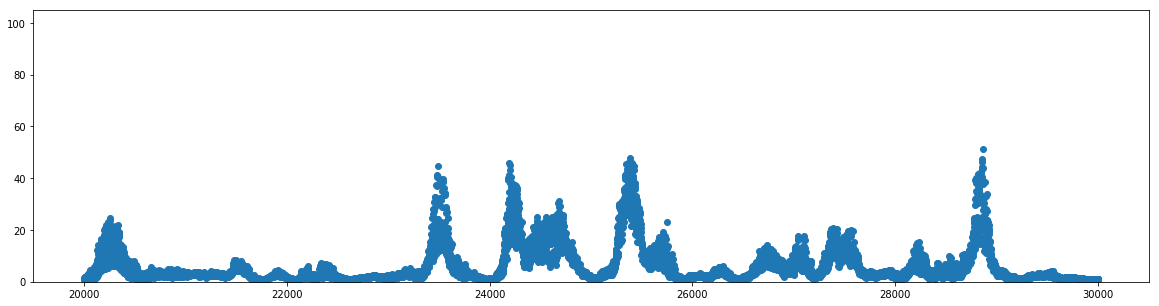

In [204]:
import statsmodels.api as sm
def regression_fit(x, y):
    results = sm.OLS(y,sm.add_constant(x)).fit()

    print (results.summary())

    plt.figure(figsize=(20, 5))
    plt.scatter(x,y)

    plt.plot(x, np.float64(x)*results.params[0] + results.params[1])
    plt.ylim(0.0, 105)
    plt.show()
regression_fit(x[0], y[0])

/home/minhoolee/.virtualenvs/python3.5/lib/python3.5/site-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/minhoolee/.virtualenvs/python3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: RankWarning: Polyfit may be poorly conditioned
  app.launch_new_instance()


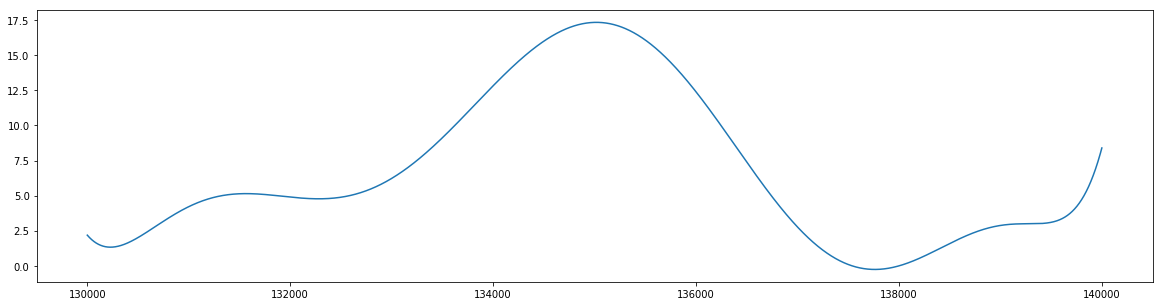

In [173]:
def polyfit_curve(x, y):
    plt.figure(figsize=(20, 5))
    z = np.polyfit(x, y, 50)
    p = np.poly1d(z)
    plt.plot(x, p(x))
    plt.show()
    
polyfit_curve(x[0], y[0])

In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

def fit_curve(x, y):
    """
    Uses Levelberg-Marquardt algorithm through leastsq
    
    http://stackoverflow.com/questions/25030675/trouble-with-curve-fitting-matplotlib
    """
    def func(x, a, b, c, d):
        return a * np.sin(b*x + c) + d
    popt, pcov = curve_fit(func, x, y)
    plt.figure(figsize=(100, 100))
    #x_lin = np.linspace(min(x), max(x), 1000)
    print(func(np.float64(x), *popt))
    plt.plot(x, func(np.float64(x), *popt), 'b-', label='fit')
    plt.show()
    
#fit_curve(x[0], y[0]*10**5)

# Prediction Generator

In [6]:
import os
os.environ["THEANO_FLAGS"] = "device=cpu"

In [7]:
import numpy as np
import h5py
import scipy.io
import time
import sys
import argparse

from os.path import isfile

from src.models.keras_model_utils import Model
from src.logging import log_utils

TRUNCATE_DATASET_RATIO = 0.5

_log = log_utils.logger(__name__)

def predict_and_save(argv):
    # Set up argument parsing
    parser = argparse.ArgumentParser(
        description='Test a Keras model on genetic sequences '
        + 'to derive epigenetic mechanisms')

    parser.add_argument('model_name', metavar='MODEL_NAME', help="The unique name of the model to create")
    parser.add_argument('fasta_file', metavar='FASTA_FILE', help="The file(valid FASTA) to open the raw data from")
    # parser.add_argument('create_fn', metavar='MODEL_FUNC', help="The name of the function in src/models/create_models to create a model with")
    parser.add_argument('weights_file', metavar='WEIGHTS_FILE', help="The file (.hdf5) to store the model's weights")
    parser.add_argument('json_file', metavar='JSON_FILE', help="The file (.json) to store the model's architecture in JSON")
    parser.add_argument('yaml_file', metavar='YAML_FILE', help="The file (.yaml) to store the model's architecture in YAML")
    parser.add_argument('log_file', metavar='LOG_FILE', help="The file (.csv) to store the model's epoch logs")
    parser.add_argument('tensorboard_dir', metavar='TB_DIR', help="The directory to store the model's tensorboard data (if using Tensorflow backend)")
    args = parser.parse_args(argv)

    data = FastaData(args.fasta_file)

    model = Model(name=args.model_name)
    model.load_from(json_file=args.json_file, yaml_file=args.yaml_file) # Temporary solution to running a model under a new name
    model.load_weights(weights_file=args.weights_file)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    _log.info('Retrieving test data...')
    test = data.get_unlabeled_prediction_data(step_size=1)

    log_utils.print_date_time(_log)
    start = time.time()

    # _log.info('Testing model...')
    # model.test(test=test)
    # log_utils.print_elapsed_time(_log, start=start, now=time.time())

    _log.info('Creating predictions...')
    y_predict = model.predict(test)

    dict = {}
    dict['predictions'] = np.array(y_predict)
    scipy.io.savemat(ROOT_DIR + 'models/predictions/y_predict_' + args.model_name + '_PPARGC1A_sliding.mat', dict)

    log_utils.print_date_time(_log)

Using Theano backend.


In [ ]:
model_name = 'conv_net_large_res_5'
argv= [model_name,
       ROOT_DIR + 'data/raw/PPARGC1A_padded.fa',
       ROOT_DIR + 'models/weights/'+model_name+'.hdf5', 
       ROOT_DIR + 'models/json/'+model_name+'.json', 
       ROOT_DIR + 'models/yaml/'+model_name+'.yaml', 
       ROOT_DIR + 'models/csv/'+model_name+'.csv', 
       ROOT_DIR + 'models/run_logs/tensorboard']
predict_and_save(argv)

## Execute all of the following

# Get File Structure

In [1]:
import os
import sys
from dotenv import load_dotenv, find_dotenv

# Find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# Load up the entries as environment variables
load_dotenv(dotenv_path)

# Get the directories of the project based off of '.env' which is in the root directory
ROOT_DIR = os.path.join(dotenv_path, os.pardir)
ROOT_DIR = dotenv_path[:-len('.env')] # Strip .env from dotenv_path to get root directory
SRC_DIR = ROOT_DIR + 'src/'

print('ROOT_DIR = {:s}'.format(ROOT_DIR))
print('SRC_DIR = {:s}'.format(SRC_DIR))

sys.path.append(os.path.normpath(ROOT_DIR))

ROOT_DIR = /home/minhoolee/Github/Synopsys-Project-2017/
SRC_DIR = /home/minhoolee/Github/Synopsys-Project-2017/src/


### FASTA Genome Data

In [3]:
from itertools import groupby
import itertools
import pandas as pd
import numpy as np

def one_hot_encode(l):
    """
    One hot encodes an one dimensional list into a numpy array
    """
    # Check if list is one dimensional, otherwise panda dataframes conversion will fail
    assert isinstance(l, list) == True
    assert isinstance(l[0], list) == False

    s = pd.Series(l)
    return (pd.get_dummies(s).values.tolist())

def _bin(l, start, stop, bin_size, step_size):
    """
    Bins a list (0 padded for incomplete lists)

    # Arguments:
        l:
            The list to bin
        bin_size:
            Size of each bin
        step_size:
            Size to shift bin and calculate new bin.
            If same as bin_size, that is the same as calculating bins with no overlap
    """
    out = []
    for i in range(start, stop, step_size):
        if i + bin_size < stop:
            out.append(l[i:i+bin_size])
        else:
            # 0 pad for incomplete bins
            rem = stop - i
            #out.append(l[i:stop] + [[0]*4]*(bin_size-rem))
            a = [l[i:stop], [[0]*4]*(bin_size-rem)]
            out.append(list(itertools.chain.from_iterable(a)))
    return out
        
class FastaData():
    def __init__(self, file_name=None):
        self.file_name = file_name
        self.headers = []
        self.seqs = []
        self.seq_lens = []
        self._populate()

    def iter(self):
        """
        https://www.biostars.org/p/710/

        Given a fasta file, yield tuples of header, sequence
        """
        fh = open(self.file_name)
        # ditch the boolean (x[0]) and just keep the header or sequence since
        # we know they alternate.
        faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))

        for header in faiter:
            # drop the ">"
            headerStr = header.__next__()[1:].strip()
            seq = "".join(s.strip() for s in faiter.__next__())

            yield (headerStr, seq)
            
    def _populate(self):
        # Grab all valid FASTAs
        f = self.iter()
        for ff in f:
            h, s = ff
            self.headers.append(h)
            self.seqs.append(s)
            self.seq_lens.append(len(s))
    
    def _bin_seqs(self, bin_size, step_size):
        """
        Bins all the raw genomic sequences according to the bin size
        """
        #out = []
        #for k in range(len(self.seqs)):
        #    out.append(_bin(list(self.seqs[k]), 0, self.seq_lens[k], bin_size))
        #return out
        return _bin(one_hot_encode(list(self.seqs[0])), 0, self.seq_lens[0], bin_size, step_size)
    
    def get_unlabeled_prediction_data(self, bin_size=1000, step_size=1000):
        """
        Returns genomic sequence in a numpy array of one hot encoded 
        bins (0 padded if bin is larger than sequence)
        Assume FASTA file can only contain one genomic sequence for now
        
        # Arguments:
            bin_size:
                Size of each bin 
        """
        #return one_hot_encode(self._bin_seqs(bin_size))
        return np.array(self._bin_seqs(bin_size, step_size))

    def get_chromosome_start_end(self):
        # TODO: automate this or use faidx
        return ''

In [4]:
import scipy.io
y_score = scipy.io.loadmat(ROOT_DIR + 'models/predictions/y_predict_conv_net_large_res_5_PPARGC1A_sliding.mat')['predictions']

In [5]:
print(len(y_score))
print(len(y_score[0]))

151047
919


In [6]:
f = FastaData(ROOT_DIR + 'data/raw/PPARGC1A_padded.fa')
print('Loading FASTA Data')
test = f.get_unlabeled_prediction_data(step_size=1)
print('Done')
print(len(test))
print(len(test[1]))
print(test[1000])

Loading FASTA Data
Done
151047
1000
[[1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 ..., 
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]]


In [7]:
print(f.headers)

['4 dna:chromosome chromosome:GRCh37:4:23755665:23906711:1']


In [11]:
axes_font = 30
title_font = 40

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from tqdm import tqdm
import seaborn as sns

sns.set_style('whitegrid')

width, height = 20, 5
plt.figure(figsize=(width, height))
plt.rcParams.update({'font.size': 70})
plt.rcParams.update({'axes.labelsize': 64})
sns.set(context='poster', style='whitegrid', palette='muted')
print('Using viewing window of size {:d} x {:d}'.format(width, height))

# TF Binding Site
valid_start = 23858380
valid_end   = 23858708
class_start = 87

# Open chromatin
#valid_start = 23829524
#valid_end   = 23829915
#class_start = 49

# Open chromatin
#valid_start = 23771636
#valid_end   = 23772072
#class_start = 61

# In implementation, I expanded the viewing window of 
# the chromosome to have 999 more bases on each side
nb_samples = len(y_score) - 999 * 2 
#nb_classes = len(y_score[0])
chrom_start = 23755665
chrom_end = 23906711
#nb_samples = 10000
#start = 1000 + valid_start -int((nb_samples+1000)/2) - chrom_start
start = 1000

class_start = 0
nb_classes = class_start + 1
#nb_classes = 5
x_scale = 1
y_scale = 100
chrom_id = 4

print('Viewing chromosome {:d} from bases {:d}:{:d}'.format(chrom_id, chrom_start, chrom_end))

def populate():
    x = [ [] for i in range(nb_classes) ]
    y = [ [] for i in range(nb_classes) ]
    
    print('Populating arrays from {:d} to {:d} for a length of {:d}...'.format(start, start + nb_samples, nb_samples))
    print('Using classes from {:d} to {:d} for total of {:d} classes'.format(class_start, nb_classes, nb_classes-class_start))
    for b in tqdm(range(start, start + nb_samples)):
        for c in range(class_start, nb_classes):
            x[c].append(x_scale * (b+chrom_start))
            y[c].append(y_scale * y_score[b][c])
    return x, y
x, y = populate()

def get_max():
    i, max = 0, 0
    for c in range(nb_classes):
        for a in range(valid_start-chrom_start, valid_end-chrom_start):
            if y_score[a][c] > max:
                max = y_score[a][c]
                i = c
                print(i, max)
    print("Best class, maximum")
    print(i, max)
    return i



def plot_predictions_sliding():

    plt.clf()
    
    x, y = populate()
            
    print('Plotting...')
    #for c, color in zip(tqdm(range(nb_classes)), tqdm(colors)):
    #print(y[class_start][0])
    #print(y[class_start+1][0])
    with sns.color_palette('muted'):
        plt.scatter(x[class_start:class_start+nb_classes], y[class_start:class_start+nb_classes], s=1)

    #plt.bar(valid_start, 100, valid_end - valid_start, color='b', alpha=0.1)
    # Generate some test data
    
    #heatmap, xedges, yedges = np.histogram2d(list(range(100)), y[0], bins=50)
    #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    #sns.set()
    #sns.heatmap((x[0], y_score[0]), annot=True, fmt='d', linewidths=0.5)
    
    plt.xlim(start+chrom_start-1, x_scale * (start + chrom_start + nb_samples + 1))
    plt.ylim(0.0, (y_scale) * 1.05)
    plt.xlabel('Position on Chromosome (Times 1e7)', fontsize=axes_font)
    plt.ylabel('Prediction percentage', fontsize=axes_font)
    plt.title('Prediction Peaks for Segment of PPARGC1A Sequence', fontsize=title_font)
    plt.show()
    #plt.clf()
    #plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='cool')
    #plt.show() 
    return x, y

 29%|██▊       | 42489/149049 [00:00<00:00, 424886.35it/s]

Using viewing window of size 20 x 5
Viewing chromosome 4 from bases 23755665:23906711
Populating arrays from 1000 to 150049 for a length of 149049...
Using classes from 0 to 1 for total of 1 classes


100%|██████████| 149049/149049 [00:00<00:00, 414567.10it/s]


 28%|██▊       | 41935/149049 [00:00<00:00, 419346.40it/s]

0 0.114565
0 0.16788
Best class, maximum
0 0.16788
Populating arrays from 1000 to 150049 for a length of 149049...
Using classes from 0 to 1 for total of 1 classes


100%|██████████| 149049/149049 [00:00<00:00, 410718.59it/s]


Plotting...


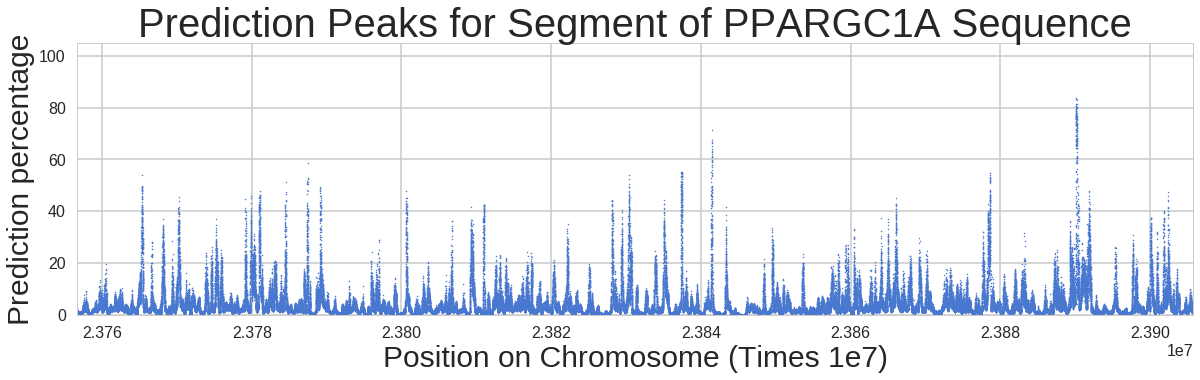

In [19]:
class_start = get_max()
nb_classes = class_start + 1

x, y = plot_predictions_sliding()

Using viewing window of size 20 x 5


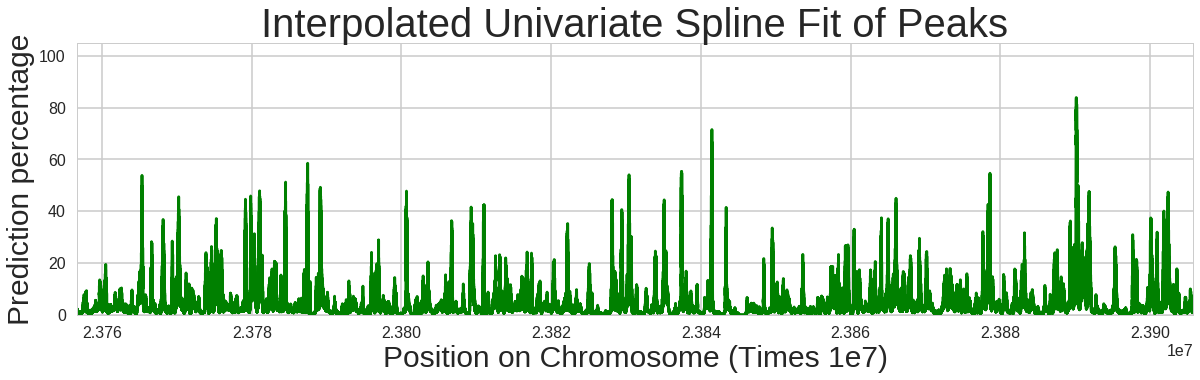

In [20]:
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
import seaborn as sns
width, height = 20, 5
plt.figure(figsize=(width, height))
plt.rcParams.update({'font.size': 18})
sns.set(context='poster', style='whitegrid', palette='muted')
print('Using viewing window of size {:d} x {:d}'.format(width, height))

def interpolate_spline(x, y):
    ius = InterpolatedUnivariateSpline(x, y)
    yi = ius(x)
    plt.plot(x, yi, 'g')
    plt.xlim(start+chrom_start-1, x_scale * (start + chrom_start + nb_samples + 1))
    plt.ylim(0.0, 105)
    plt.xlabel('Position on Chromosome (Times 1e7)', fontsize=axes_font)
    plt.ylabel('Prediction percentage', fontsize=axes_font)
    plt.title('Interpolated Univariate Spline Fit of Peaks', fontsize=title_font)
    plt.show()
    #plt.figure(figsize=(20, 5))
    #rbf=Rbf(x, y)
    #yi=rbf(x)
    #plt.plot(x, yi, 'g')
    #plt.title('Interpolated Univariate Spline Fit')
    #plt.ylim(0.0, 105)
    #plt.show()
    
interpolate_spline(x[0], y[0]) 